# Optimization Loops

During this lesson, we will learn how to use an *optimizer* to iteratively explore the parameterized quantum states of our ansatz:

- Bootstrap an optimization loop  
- Understand trade-offs while using local and global optimizers  
- Explore barren plateaus and how to avoid them

At a high level, optimizers are central to exploring our search space. The optimizer uses cost function evaluations to select the next set of parameters in a variational loop, and repeats the process until it reaches a stable state. At this stage, an optimal set of parameter values $\vec{\theta}^*$ is returned.


![alt text](../../../img/optimization_workflow.svg)

# Table of Contents

1. [Local and Global Optimizers](#local-and-global-optimizers)  
   - [Local Optimizers](#local-optimizers)  
   - [Global Optimizers](#global-optimizers)  
   - [Bootstrapping Optimization](#bootstrapping-optimization)  
2. [Gradient-Based and Gradient-Free Optimizers](#gradient-based-and-gradient-free-optimizers)  
   - [Gradient-Based](#gradient-based)  
   - [Gradient-Free](#gradient-free)  
3. [Barren Plateaus](#barren-plateaus)  
4. [Summary](#summary)


## Local and Global Optimizers


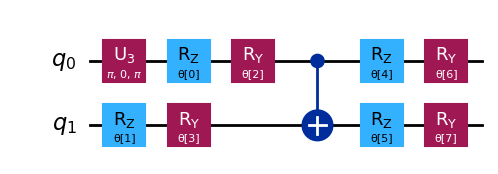

In [7]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

In [8]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

In [9]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

### Local Optimizers
Local optimizers search for a point that minimizes the cost function starting at an initial point(s) $C(\vec{\theta_0})$ and move to different points based on what they observe in the region they are currently evaluating on successive iterations. This implies that the convergence of these algorithms will usually be fast, but can be heavily dependent on the initial point. Local optimizers are unable to see beyond the region where they are evaluating and can be especially vulnerable to local minima, reporting convergence when they find one and ignoring other states with more favorable evaluations.

In [10]:
# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="SLSQP")

result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.999999996457203
       x: [ 1.000e+00  1.000e+00 -1.571e+00 -4.548e-05 -1.207e+00
           -1.935e+00  4.079e-01 -4.079e-01]
     nit: 12
     jac: [-1.490e-07 -1.490e-07 -7.958e-04  2.542e-04  1.381e-03
            1.381e-03  5.432e-04  5.432e-04]
    nfev: 112
    njev: 12

### Global Optimizers

Global optimizers search for the point that minimizes the cost function over several regions of its domain (i.e., non-local), evaluating it iteratively (i.e., at iteration $i$) over a set of parameter vectors  
$\Theta_i := \vec{\theta}_{i,j}, j \in \mathcal{T}_{\text{opt}}^i$ determined by the optimizer. This makes them less susceptible to local minima and somewhat independent of initialization, but also significantly slower to converge to a proposed solution.

### Bootstrapping Optimization

*Bootstrapping*, or setting the initial value for parameters $\vec{\theta}$ based on a prior optimization, can help our optimizer converge on a solution faster. We refer to this as the initial point $\vec{\theta}_0$, and  
$|\psi(\vec{\theta}_0)\rangle = U_V(\vec{\theta}_0)|\rho\rangle$ as the initial state. This initial state differs from our reference state $|\rho\rangle$, as the former focuses on initial parameters set during our optimization loop, while the latter focuses on using known "reference" solutions. They may coincide if $U_V(\vec{\theta}_0) \equiv I$ (i.e., the identity operation).

When local optimizers converge to non-optimal local minima, we can try bootstrapping the optimization globally and refine the convergence locally. While this requires setting up two variational workloads, it allows the optimizer to find a more optimal solution than the local optimizer alone.

## Gradient-Based and Gradient-Free Optimizers


### Gradient-Based

For our cost function $C(\vec{\theta})$, if we have access to the gradient of the function $\vec{\nabla} C(\vec{\theta})$ starting from an initial point, the simplest way to minimize the function is to update the parameters toward the direction of steepest descent of the function. That is, we update the parameters as  
$\vec{\theta}_{n+1} = \vec{\theta}_n - \eta \vec{\nabla} C(\vec{\theta})$,  
where $\eta$ is the learning rate – a small, positive *hyperparameter* that controls the size of the update. We continue doing this until we converge to a local minimum of the cost function, $C(\vec{\theta}^*)$.

We can use the cost function and an optimizer to calculate optimal parameters.


In [11]:
# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="BFGS")

result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -3.999999999999794
        x: [ 1.000e+00  1.000e+00  1.571e+00  2.789e-07  2.009e-01
            -2.009e-01  6.342e-01 -6.342e-01]
      nit: 14
      jac: [-1.192e-07 -2.980e-08  7.153e-07  8.941e-07  5.960e-08
             5.960e-08 -2.980e-08 -2.980e-08]
 hess_inv: [[ 1.000e+00  1.440e-08 ... -5.415e-05 -4.167e-05]
            [ 1.440e-08  1.000e+00 ... -7.245e-05 -5.848e-05]
            ...
            [-5.415e-05 -7.245e-05 ...  7.243e-01 -2.604e-01]
            [-4.167e-05 -5.848e-05 ... -2.604e-01  8.179e-01]]
     nfev: 144
     njev: 16

The main disadvantages of this type of optimization are the convergence speed, which can be very slow, and there is no guarantee to achieve the optimal solution.

![alt text](../../../img/optimization_gradient_descent.svg)

### Gradient-Free

Gradient-free optimization algorithms do not require gradient information and can be useful in situations where computing the gradient is difficult, expensive, or too noisy. They also tend to be more robust in finding global optima, whereas gradient-based methods tend to converge to local optima. We'll explore a few instances where a gradient-free optimizer can help avoid barren plateaus. However, gradient-free methods require higher computational resources, especially for problems with high-dimensional search spaces.

Here's an example that uses the `COBYLA` optimizer instead:


In [12]:
# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA")

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.99999998712996
       x: [ 1.454e+00  1.173e+00  1.571e+00  3.142e+00  1.615e+00
           -1.526e+00  1.330e+00  1.812e+00]
    nfev: 175
   maxcv: 0.0

## Barren Plateaus

In fact, the cost landscape can be quite complicated, as shown by the hills and valleys in the example below. The optimization method navigates us around the cost landscape, searching for the minimum, as shown by the black points and lines. We can see that two of the three searches end up in a local minimum of the landscape, rather than a global one.



Regardless of the type of optimization method used, if the cost landscape is relatively flat, it can be challenging for the method to determine the appropriate direction to search. This scenario is referred to as a barren plateau, where the cost landscape becomes progressively flatter (and thus more challenging to determine the direction to the minimum). For a broad range of parameterized quantum circuits, the probability that the gradient along any reasonable direction is non-zero to some fixed precision decreases exponentially as the number of qubits increases.



While this area is still under active research, we have a few recommendations to improve optimization performance:

- Bootstrapping can help the optimization loop avoid getting stuck in a parameter space where the gradient is small.
- Experimenting with hardware-efficient ansatz: Since we're using a noisy quantum system as a black-box oracle, the quality of those evaluations can affect the optimizer's performance. Using hardware-efficient ansatz, such as `EfficientSU2`, may avoid producing exponentially small gradients.
- Experimenting with error suppression and error mitigation: the Qiskit Runtime primitives provide a simple interface to experiment with various optimization_level s and resilience_setting s respectively. This can reduce the impact of noise and make the optimization process more efficient.
- Experimenting with gradient-free optimizers: Unlike gradient-based optimization algorithms, optimizers such as COBYLA do not rely on gradient information to optimize the parameters and are therefore less likely to be affected by the barren plateau.

## Summary

With this lesson, you learned how to define your optimization loop:

- Bootstrap an optimization loop
- Understand trade-offs while using local and global optimizers
- Explore barren plateaus and how to avoid them

Our high-level variational workload is complete:

![alt text](../../../img/optimization_circuit.svg)

Next, we'll explore specific variational algorithms with this framework in mind.